Generative adversarial networks (GANs) are an alternative to VAEs for learning latent spaces of images. They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones.

A GAN is made up by a forger network and an expert network, each being trained to best the other. As such, a GAN is made of two parts:
1. _Generator network_ — Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image
2. _Discriminator network (or adversary)_ — Takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the generator network.

A GAN is a system where the optimization minimum isn’t fixed, unlike in any other training setup you’ve encountered in this book. Normally, gradient descent consists of rolling down hills in a static loss landscape. But with a GAN, every step taken down the hill changes the entire landscape a little. It’s a dynamic system where the optimization process is seeking not a minimum, but an equilibrium between two forces. For this reason, GANs are notoriously difficult to train—getting a GAN to work requires lots of careful tuning of the model architecture and training parameters.

We implement an example that, schematically, looks like this:
1. A generator network maps vectors of shape (latent_dim,) to images of shape (32, 32, 3).
2. A discriminator network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
3. A gan network chains the generator and the discriminator together: gan(x) = discriminator(generator(x)). Thus this gan network maps latent space vec- tors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.
4. You train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as you train any regular image-classification model.
5. To train the generator, you use the gradients of the generator’s weights with regard to the loss of the gan model. This means, at every step, you move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, you train the generator to fool the discriminator.

First, let’s develop a `generator` model that turns a vector (from the latent space— during training it will be sampled at random) into a candidate image.

In [1]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

Now, let's develop a discriminator model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: **“generated image”** or **“real image that comes from the training set.”**

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
 
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# Add a dropout layer to introduce randomness and avoid that the GAN gets stuck
x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [3]:
discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer,
                     loss='binary_crossentropy')

And, finally, let's build the whole adversarial network, which chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its ability to fool the discriminator. Training `gan` will update the weights of generator in a way that makes discriminator more likely to predict “real” when looking at fake images. It’s very important to note that you set the discriminator to be frozen during training (non-trainable): its weights won’t be updated when training gan. If the discriminator weights could be updated during this process, then you’d be training the discrimina- tor to always predict “real,” which isn’t what you want!

In [4]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Finally, let's train the GAN. We will follow this approach:
1. Draw random points in the latent space (random noise).
2. Generate images with `generator` using this random noise.
3. Mix the generated images with real ones.
4. Train `discriminator` using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images).
5. Draw new random points in the latent space.
6. Train gan using these random vectors, with targets that all say “these are real images.” This updates the weights of the `generator` (only, because the `discriminator` is frozen inside `gan`) to move them toward getting the `discriminator` to predict “these are real images” for generated images: this trains the `generator` to fool the `discriminator`.

In [5]:
import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 175s 1us/step


In [6]:
# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [7]:
iterations = 10000
batch_size = 20
save_dir = '/home/ec2-user/imgs'

In [8]:
start = 0
for step in range(iterations):
    # sample random points in latent space (using a normal distribution)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # decode them to fake images using the generator
    generated_images = generator.predict(random_latent_vectors)
    # combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    # assemble labels, discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    # we add random noise (a trick to avoid the GAN getting stuck)
    labels += 0.05 * np.random.random(labels.shape)
    
    # we train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # again, sample random points in latent space (using a normal distribution)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # assemble labels that all say "these are real images"
    misleading_targets = np.zeros((batch_size, 1))
    # train the generator via the gan model (the discriminator's weights are frozen in this case)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        
    print('discriminator loss:', d_loss)
    print('adversarial loss:', a_loss)
    
    # saves one generated image
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
    
    # saves one real image for comparison
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/usr/local/lib64/python3.4/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss: 0.70342594
adversarial loss: 0.6742525
discriminator loss: 4.7442827
adversarial loss: 15.540881
discriminator loss: 3.92906
adversarial loss: 7.0483648e-06
discriminator loss: 6.542315
adversarial loss: 1.250787
discriminator loss: 0.8055886
adversarial loss: 1.9327096
discriminator loss: 0.27637392
adversarial loss: 3.7748725
discriminator loss: 3.9521284
adversarial loss: 1.0442933
discriminator loss: 0.83200985
adversarial loss: 0.9956619
discriminator loss: 0.42591017
adversarial loss: 7.9803357
discriminator loss: 0.7370415
adversarial loss: 0.9972354
discriminator loss: 0.6451458
adversarial loss: 1.8289018
discriminator loss: 0.5841372
adversarial loss: 1.6470804
discriminator loss: 0.5204388
adversarial loss: 2.1371913
discriminator loss: 0.567613
adversarial loss: 0.88701004
discriminator loss: 0.7149891
adversarial loss: 1.4049624
discriminator loss: 0.6850465
adversarial loss: 1.3333943
discriminator loss: 0.553356
adversarial loss: 2.586372
discriminato

discriminator loss: 0.6984991
adversarial loss: 1.1303116
discriminator loss: 0.7863846
adversarial loss: 0.80637026
discriminator loss: 0.7311981
adversarial loss: 0.8100121
discriminator loss: 0.6858582
adversarial loss: 0.75490284
discriminator loss: 0.68723255
adversarial loss: 0.8284421
discriminator loss: 0.6861667
adversarial loss: 0.88841224
discriminator loss: 0.69332266
adversarial loss: 0.84227246
discriminator loss: 0.72930646
adversarial loss: 0.96641237
discriminator loss: 0.69903594
adversarial loss: 0.96503824
discriminator loss: 0.66789776
adversarial loss: 0.90534186
discriminator loss: 0.66526115
adversarial loss: 0.90389735
discriminator loss: 0.664092
adversarial loss: 0.9973143
discriminator loss: 0.7267468
adversarial loss: 1.4357575
discriminator loss: 0.65024126
adversarial loss: 1.5403103
discriminator loss: 0.73872095
adversarial loss: 5.281043
discriminator loss: 1.42026
adversarial loss: 1.8795885
discriminator loss: 0.6705792
adversarial loss: 1.4660149
di

discriminator loss: 0.69607145
adversarial loss: 0.7135345
discriminator loss: 0.70735925
adversarial loss: 0.7586622
discriminator loss: 0.6960453
adversarial loss: 0.86281836
discriminator loss: 0.71731234
adversarial loss: 0.83654684
discriminator loss: 0.7230879
adversarial loss: 0.770974
discriminator loss: 0.687403
adversarial loss: 0.7338261
discriminator loss: 0.6899365
adversarial loss: 0.71200335
discriminator loss: 0.78350127
adversarial loss: 0.6871586
discriminator loss: 0.69073325
adversarial loss: 0.7397493
discriminator loss: 0.689088
adversarial loss: 0.7797731
discriminator loss: 0.6879104
adversarial loss: 0.7620821
discriminator loss: 0.710914
adversarial loss: 0.7378416
discriminator loss: 0.6927879
adversarial loss: 0.7243184
discriminator loss: 0.6942943
adversarial loss: 0.7308743
discriminator loss: 0.69733053
adversarial loss: 0.74880964
discriminator loss: 0.68893075
adversarial loss: 0.71808887
discriminator loss: 0.6780176
adversarial loss: 0.7509496
discri

discriminator loss: 0.70038795
adversarial loss: 0.7318601
discriminator loss: 0.69498503
adversarial loss: 0.7378429
discriminator loss: 0.69515824
adversarial loss: 0.74752104
discriminator loss: 0.68745166
adversarial loss: 0.7419043
discriminator loss: 0.69067556
adversarial loss: 0.7657324
discriminator loss: 0.6985359
adversarial loss: 0.7436147
discriminator loss: 0.7106098
adversarial loss: 0.8830199
discriminator loss: 0.71686625
adversarial loss: 0.72791326
discriminator loss: 0.70769936
adversarial loss: 0.77240074
discriminator loss: 0.71061265
adversarial loss: 0.7536807
discriminator loss: 0.697075
adversarial loss: 0.7276998
discriminator loss: 0.6988421
adversarial loss: 0.7426764
discriminator loss: 0.70380706
adversarial loss: 0.7458558
discriminator loss: 0.6960367
adversarial loss: 0.74048054
discriminator loss: 0.6936729
adversarial loss: 0.7332636
discriminator loss: 0.6958585
adversarial loss: 0.72961485
discriminator loss: 0.69217664
adversarial loss: 0.73012185

discriminator loss: 0.6998334
adversarial loss: 0.82969695
discriminator loss: 0.6947067
adversarial loss: 0.7379536
discriminator loss: 0.6917054
adversarial loss: 0.7304896
discriminator loss: 0.6957594
adversarial loss: 0.7391099
discriminator loss: 0.6889316
adversarial loss: 0.75531125
discriminator loss: 0.6867314
adversarial loss: 0.78689456
discriminator loss: 0.69447917
adversarial loss: 0.74261737
discriminator loss: 0.6969857
adversarial loss: 0.7309731
discriminator loss: 0.6905085
adversarial loss: 0.74564266
discriminator loss: 0.6881016
adversarial loss: 0.7456193
discriminator loss: 0.6879573
adversarial loss: 0.7478854
discriminator loss: 0.703273
adversarial loss: 0.7361175
discriminator loss: 0.686346
adversarial loss: 0.76158655
discriminator loss: 0.69504154
adversarial loss: 0.75156367
discriminator loss: 0.69445133
adversarial loss: 0.7345933
discriminator loss: 0.68965834
adversarial loss: 0.7525066
discriminator loss: 0.68521655
adversarial loss: 0.7574252
disc

discriminator loss: 0.72163105
adversarial loss: 0.8047114
discriminator loss: 0.7083127
adversarial loss: 0.7765645
discriminator loss: 0.6999309
adversarial loss: 0.751078
discriminator loss: 0.69300526
adversarial loss: 0.7499622
discriminator loss: 0.69093823
adversarial loss: 0.74529004
discriminator loss: 0.69075
adversarial loss: 0.77375615
discriminator loss: 0.68893325
adversarial loss: 0.8878099
discriminator loss: 0.7488017
adversarial loss: 0.7846596
discriminator loss: 0.68915975
adversarial loss: 0.7821542
discriminator loss: 0.70349056
adversarial loss: 0.7408274
discriminator loss: 0.6905598
adversarial loss: 0.7477291
discriminator loss: 0.6916314
adversarial loss: 0.74322426
discriminator loss: 0.7162051
adversarial loss: 0.7488465
discriminator loss: 0.6981544
adversarial loss: 0.7655059
discriminator loss: 0.6912604
adversarial loss: 0.7693753
discriminator loss: 0.69154227
adversarial loss: 0.73736215
discriminator loss: 0.721803
adversarial loss: 0.7928568
discrim

discriminator loss: 0.69312894
adversarial loss: 0.72297126
discriminator loss: 0.68742687
adversarial loss: 0.8207674
discriminator loss: 0.6974406
adversarial loss: 0.7397048
discriminator loss: 0.72234416
adversarial loss: 0.7897923
discriminator loss: 0.6902248
adversarial loss: 0.7543985
discriminator loss: 0.68682325
adversarial loss: 0.7081434
discriminator loss: 0.7543496
adversarial loss: 0.7889599
discriminator loss: 0.70385456
adversarial loss: 0.7695797
discriminator loss: 0.7038033
adversarial loss: 0.75433254
discriminator loss: 0.6866345
adversarial loss: 0.78029317
discriminator loss: 0.68251073
adversarial loss: 0.78969806
discriminator loss: 0.6905981
adversarial loss: 0.7935331
discriminator loss: 0.6967072
adversarial loss: 0.7803639
discriminator loss: 0.674805
adversarial loss: 0.8181349
discriminator loss: 0.7101835
adversarial loss: 0.762027
discriminator loss: 0.68794096
adversarial loss: 0.75111145
discriminator loss: 0.70328426
adversarial loss: 0.7798665
dis

discriminator loss: 0.7056078
adversarial loss: 0.76974595
discriminator loss: 0.69854355
adversarial loss: 0.7493704
discriminator loss: 0.69502234
adversarial loss: 0.7493241
discriminator loss: 0.69834256
adversarial loss: 0.7524945
discriminator loss: 0.6904049
adversarial loss: 0.73993015
discriminator loss: 0.69235194
adversarial loss: 0.74989545
discriminator loss: 0.68818563
adversarial loss: 0.7993436
discriminator loss: 0.6982089
adversarial loss: 0.7950698
discriminator loss: 0.7118288
adversarial loss: 0.78506756
discriminator loss: 0.69095784
adversarial loss: 0.7940842
discriminator loss: 0.69673383
adversarial loss: 0.74707276
discriminator loss: 0.70903796
adversarial loss: 0.76237583
discriminator loss: 0.69022644
adversarial loss: 0.759322
discriminator loss: 0.6945169
adversarial loss: 0.796067
discriminator loss: 0.6858158
adversarial loss: 0.81470007
discriminator loss: 0.6969001
adversarial loss: 0.6951354
discriminator loss: 0.7316574
adversarial loss: 0.7547407


discriminator loss: 0.68249846
adversarial loss: 0.7479667
discriminator loss: 0.6954263
adversarial loss: 0.7467032
discriminator loss: 0.69906586
adversarial loss: 0.72669905
discriminator loss: 0.70873845
adversarial loss: 0.7490594
discriminator loss: 0.69051385
adversarial loss: 0.738098
discriminator loss: 0.70510334
adversarial loss: 0.7526682
discriminator loss: 0.6973747
adversarial loss: 0.7593523
discriminator loss: 0.66523916
adversarial loss: 0.39991376
discriminator loss: 1.2113702
adversarial loss: 0.73122585
discriminator loss: 0.68081737
adversarial loss: 0.7481787
discriminator loss: 0.72157025
adversarial loss: 0.7273476
discriminator loss: 0.69928265
adversarial loss: 0.7327007
discriminator loss: 0.6984823
adversarial loss: 0.7297445
discriminator loss: 0.6993181
adversarial loss: 0.7463896
discriminator loss: 0.7014534
adversarial loss: 0.7302804
discriminator loss: 0.6841614
adversarial loss: 0.72963494
discriminator loss: 0.68110526
adversarial loss: 0.72811574


discriminator loss: 0.70784116
adversarial loss: 0.7557125
discriminator loss: 0.7010689
adversarial loss: 0.7595756
discriminator loss: 0.6970424
adversarial loss: 0.74933076
discriminator loss: 0.68992734
adversarial loss: 0.75687814
discriminator loss: 0.6861557
adversarial loss: 0.75001144
discriminator loss: 0.6979902
adversarial loss: 0.753855
discriminator loss: 0.696789
adversarial loss: 0.77736574
discriminator loss: 0.70787287
adversarial loss: 0.7648864
discriminator loss: 0.69297856
adversarial loss: 0.7711897
discriminator loss: 0.6960577
adversarial loss: 0.75470597
discriminator loss: 0.6987032
adversarial loss: 0.7662429
discriminator loss: 0.689613
adversarial loss: 0.8988408
discriminator loss: 0.93390346
adversarial loss: 0.7833401
discriminator loss: 0.70371926
adversarial loss: 0.7525885
discriminator loss: 0.7248617
adversarial loss: 0.93349063
discriminator loss: 0.6899159
adversarial loss: 0.78388953
discriminator loss: 0.6914572
adversarial loss: 0.7410119
disc

discriminator loss: 0.6843493
adversarial loss: 0.7819491
discriminator loss: 0.6956584
adversarial loss: 0.7826811
discriminator loss: 0.69512707
adversarial loss: 0.7892947
discriminator loss: 0.7178161
adversarial loss: 0.7377982
discriminator loss: 0.69961846
adversarial loss: 0.85560703
discriminator loss: 0.6965182
adversarial loss: 0.8138126
discriminator loss: 0.6941609
adversarial loss: 1.0506315
discriminator loss: 0.7353286
adversarial loss: 0.64736044
discriminator loss: 1.1704816
adversarial loss: 0.79280275
discriminator loss: 0.7382605
adversarial loss: 0.8318527
discriminator loss: 0.68381804
adversarial loss: 0.728946
discriminator loss: 0.6934358
adversarial loss: 0.6683462
discriminator loss: 0.76774156
adversarial loss: 0.7351769
discriminator loss: 0.6856639
adversarial loss: 0.94322276
discriminator loss: 0.7563261
adversarial loss: 0.760654
discriminator loss: 0.68785214
adversarial loss: 0.7907033
discriminator loss: 0.6836014
adversarial loss: 0.788043
discrimi

discriminator loss: 0.6937573
adversarial loss: 0.8162063
discriminator loss: 0.7166619
adversarial loss: 0.74677396
discriminator loss: 0.70164263
adversarial loss: 0.7511406
discriminator loss: 0.68752337
adversarial loss: 0.74848336
discriminator loss: 0.69660306
adversarial loss: 0.7629111
discriminator loss: 0.6816041
adversarial loss: 0.7501787
discriminator loss: 0.7078341
adversarial loss: 0.74126387
discriminator loss: 0.68793297
adversarial loss: 0.7243736
discriminator loss: 0.69370943
adversarial loss: 0.7303937
discriminator loss: 0.6961399
adversarial loss: 1.1358786
discriminator loss: 0.89415425
adversarial loss: 0.7991684
discriminator loss: 0.68867826
adversarial loss: 0.78776973
discriminator loss: 0.68802744
adversarial loss: 0.77007097
discriminator loss: 0.7824761
adversarial loss: 0.7368547
discriminator loss: 0.7001432
adversarial loss: 0.7740287
discriminator loss: 0.70036685
adversarial loss: 0.77784383
discriminator loss: 0.69083726
adversarial loss: 0.756884

discriminator loss: 0.6889285
adversarial loss: 0.7645351
discriminator loss: 0.70064896
adversarial loss: 0.7619295
discriminator loss: 0.697724
adversarial loss: 0.765766
discriminator loss: 0.6982929
adversarial loss: 0.7430958
discriminator loss: 0.69416934
adversarial loss: 0.75132596
discriminator loss: 0.68419254
adversarial loss: 0.73407525
discriminator loss: 0.70411617
adversarial loss: 0.76421064
discriminator loss: 0.6829425
adversarial loss: 0.7520944
discriminator loss: 0.6875514
adversarial loss: 0.7567959
discriminator loss: 0.7091212
adversarial loss: 0.73427457
discriminator loss: 0.6934446
adversarial loss: 0.7012156
discriminator loss: 0.7028593
adversarial loss: 0.89914024
discriminator loss: 0.71929514
adversarial loss: 0.83214206
discriminator loss: 0.6927434
adversarial loss: 0.8055137
discriminator loss: 0.71188194
adversarial loss: 0.7240516
discriminator loss: 0.68971276
adversarial loss: 0.73022044
discriminator loss: 0.69209504
adversarial loss: 0.77908325


discriminator loss: 0.6960729
adversarial loss: 0.71925455
discriminator loss: 0.6843982
adversarial loss: 0.71677923
discriminator loss: 0.69466746
adversarial loss: 0.7207159
discriminator loss: 0.69685787
adversarial loss: 0.71789837
discriminator loss: 0.69839
adversarial loss: 0.7371858
discriminator loss: 0.6965433
adversarial loss: 0.7157053
discriminator loss: 0.6935446
adversarial loss: 0.7258924
discriminator loss: 0.69304186
adversarial loss: 0.71433425
discriminator loss: 0.6941301
adversarial loss: 0.7227583
discriminator loss: 0.6760273
adversarial loss: 0.7365593
discriminator loss: 0.7067671
adversarial loss: 0.72542727
discriminator loss: 0.68453085
adversarial loss: 0.72566104
discriminator loss: 0.7002461
adversarial loss: 0.73619604
discriminator loss: 0.69667804
adversarial loss: 0.7240083
discriminator loss: 0.6966214
adversarial loss: 0.7460067
discriminator loss: 0.7000316
adversarial loss: 0.727101
discriminator loss: 0.69394517
adversarial loss: 0.7434102
disc

discriminator loss: 0.7142317
adversarial loss: 0.7327645
discriminator loss: 0.7059118
adversarial loss: 0.74442947
discriminator loss: 0.70691735
adversarial loss: 0.7338394
discriminator loss: 0.705384
adversarial loss: 0.8645092
discriminator loss: 0.7286533
adversarial loss: 0.72429824
discriminator loss: 0.6816509
adversarial loss: 0.71754587
discriminator loss: 0.678364
adversarial loss: 0.7220332
discriminator loss: 0.7227692
adversarial loss: 0.73440653
discriminator loss: 0.7126322
adversarial loss: 0.7373285
discriminator loss: 0.6938361
adversarial loss: 0.7486408
discriminator loss: 0.6928544
adversarial loss: 0.75843143
discriminator loss: 0.698566
adversarial loss: 0.74181914
discriminator loss: 0.6866449
adversarial loss: 0.7605804
discriminator loss: 0.68503475
adversarial loss: 0.7505479
discriminator loss: 0.6981305
adversarial loss: 0.73764426
discriminator loss: 0.68639505
adversarial loss: 0.75146115
discriminator loss: 0.69460016
adversarial loss: 0.7456453
discr

discriminator loss: 0.69288087
adversarial loss: 0.69652456
discriminator loss: 0.6953352
adversarial loss: 0.72581184
discriminator loss: 0.6953518
adversarial loss: 0.76008034
discriminator loss: 0.7112759
adversarial loss: 0.72309905
discriminator loss: 0.6976429
adversarial loss: 0.7375818
discriminator loss: 0.6865571
adversarial loss: 0.7174441
discriminator loss: 0.7081953
adversarial loss: 0.7319274
discriminator loss: 0.69352895
adversarial loss: 0.72023535
discriminator loss: 0.6941141
adversarial loss: 0.733814
discriminator loss: 0.68843627
adversarial loss: 0.7128004
discriminator loss: 0.69479644
adversarial loss: 0.8355005
discriminator loss: 0.7155032
adversarial loss: 0.74107087
discriminator loss: 0.6928168
adversarial loss: 0.7635265
discriminator loss: 0.70383453
adversarial loss: 0.7404134
discriminator loss: 0.6864747
adversarial loss: 0.7285197
discriminator loss: 0.6891563
adversarial loss: 0.7180371
discriminator loss: 0.69155586
adversarial loss: 0.736348
disc

discriminator loss: 0.68422985
adversarial loss: 0.7593789
discriminator loss: 0.6956731
adversarial loss: 0.7507946
discriminator loss: 0.68232477
adversarial loss: 0.7703508
discriminator loss: 0.70739055
adversarial loss: 0.7531023
discriminator loss: 0.7046666
adversarial loss: 0.7461047
discriminator loss: 0.70107
adversarial loss: 0.74128556
discriminator loss: 0.68798816
adversarial loss: 0.7993617
discriminator loss: 0.699851
adversarial loss: 0.75455356
discriminator loss: 0.69701385
adversarial loss: 0.7061542
discriminator loss: 0.7711019
adversarial loss: 0.786696
discriminator loss: 0.70650613
adversarial loss: 0.7845766
discriminator loss: 0.6918311
adversarial loss: 0.83132184
discriminator loss: 0.7867652
adversarial loss: 0.76476467
discriminator loss: 0.6878966
adversarial loss: 0.76013815
discriminator loss: 0.7065417
adversarial loss: 0.7793081
discriminator loss: 0.6891625
adversarial loss: 0.7730509
discriminator loss: 0.6989346
adversarial loss: 0.7773487
discrim

discriminator loss: 0.7628754
adversarial loss: 0.750512
discriminator loss: 0.6777425
adversarial loss: 0.893269
discriminator loss: 0.6969929
adversarial loss: 0.750661
discriminator loss: 0.69460917
adversarial loss: 0.77650416
discriminator loss: 0.6820116
adversarial loss: 0.77772224
discriminator loss: 0.68669987
adversarial loss: 0.745141
discriminator loss: 0.7148471
adversarial loss: 0.73818195
discriminator loss: 0.7033317
adversarial loss: 0.77978957
discriminator loss: 0.6908416
adversarial loss: 0.7559713
discriminator loss: 0.6987266
adversarial loss: 0.76105106
discriminator loss: 0.6847615
adversarial loss: 0.7627147
discriminator loss: 0.69420266
adversarial loss: 0.7429435
discriminator loss: 0.68917805
adversarial loss: 0.74783885
discriminator loss: 0.7077602
adversarial loss: 0.73134494
discriminator loss: 0.70875365
adversarial loss: 0.73244643
discriminator loss: 0.71001846
adversarial loss: 0.75823057
discriminator loss: 0.68494594
adversarial loss: 0.7465521
di

discriminator loss: 0.69052625
adversarial loss: 0.75374115
discriminator loss: 0.69808793
adversarial loss: 0.76236856
discriminator loss: 0.69709146
adversarial loss: 0.7563505
discriminator loss: 0.700896
adversarial loss: 0.7274086
discriminator loss: 0.68963325
adversarial loss: 0.7462693
discriminator loss: 0.6975124
adversarial loss: 0.7864285
discriminator loss: 0.68904954
adversarial loss: 0.7731367
discriminator loss: 0.68938947
adversarial loss: 0.7532543
discriminator loss: 0.68671894
adversarial loss: 0.7915932
discriminator loss: 0.71251774
adversarial loss: 0.7310318
discriminator loss: 0.6932174
adversarial loss: 0.7216902
discriminator loss: 0.69125295
adversarial loss: 0.7072943
discriminator loss: 0.6863977
adversarial loss: 0.7349049
discriminator loss: 0.69324267
adversarial loss: 0.76858103
discriminator loss: 0.7091906
adversarial loss: 0.7434217
discriminator loss: 0.6934663
adversarial loss: 0.7174672
discriminator loss: 0.7403158
adversarial loss: 0.74229205
d

discriminator loss: 0.70629895
adversarial loss: 0.7561403
discriminator loss: 0.6961394
adversarial loss: 0.75328255
discriminator loss: 0.69670725
adversarial loss: 0.76174843
discriminator loss: 0.69304913
adversarial loss: 0.7559063
discriminator loss: 0.6919308
adversarial loss: 0.748231
discriminator loss: 0.6973084
adversarial loss: 0.80078
discriminator loss: 0.7086975
adversarial loss: 0.7732407
discriminator loss: 0.694911
adversarial loss: 0.767414
discriminator loss: 0.68458134
adversarial loss: 1.0579275
discriminator loss: 0.6965434
adversarial loss: 0.7345333
discriminator loss: 0.69917166
adversarial loss: 0.7192184
discriminator loss: 0.70291674
adversarial loss: 0.7103661
discriminator loss: 0.6933993
adversarial loss: 0.70449054
discriminator loss: 0.6906405
adversarial loss: 0.7416027
discriminator loss: 0.68357456
adversarial loss: 0.688118
discriminator loss: 0.70387644
adversarial loss: 0.8309775
discriminator loss: 0.69399285
adversarial loss: 0.7058126
discrimi

discriminator loss: 0.69720376
adversarial loss: 0.7256698
discriminator loss: 0.69692314
adversarial loss: 0.7405515
discriminator loss: 0.68937624
adversarial loss: 0.7605249
discriminator loss: 0.6952134
adversarial loss: 0.7621018
discriminator loss: 0.6907267
adversarial loss: 0.7538156
discriminator loss: 0.6924005
adversarial loss: 0.71817106
discriminator loss: 0.6885537
adversarial loss: 0.75919855
discriminator loss: 0.7083563
adversarial loss: 0.7259022
discriminator loss: 0.706386
adversarial loss: 0.73252857
discriminator loss: 0.7024099
adversarial loss: 0.73840547
discriminator loss: 0.69735587
adversarial loss: 0.75295055
discriminator loss: 0.69472706
adversarial loss: 0.7533618
discriminator loss: 0.6920587
adversarial loss: 0.77484226
discriminator loss: 0.68617207
adversarial loss: 1.5008403
discriminator loss: 0.8656867
adversarial loss: 0.7888824
discriminator loss: 0.7087316
adversarial loss: 0.7864969
discriminator loss: 0.684018
adversarial loss: 0.78899264
dis

KeyboardInterrupt: 

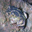

In [15]:
# Plot some real frogs
from IPython.display import Image
Image("/home/ec2-user/imgs/real_frog2715.png")

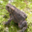

In [16]:
Image("/home/ec2-user/imgs/real_frog2716.png")

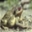

In [17]:
Image("/home/ec2-user/imgs/real_frog2717.png")

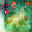

In [18]:
# Plot some generated frogs
Image("/home/ec2-user/imgs/generated_frog2715.png")

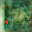

In [19]:
Image("/home/ec2-user/imgs/generated_frog2716.png")

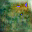

In [20]:
Image("/home/ec2-user/imgs/generated_frog2717.png")